# 14-3-loop.ipynb

This notebook loads truth and reco level data from the prepped h5 files, preprocesses the data (i.e. scales them to be between -1 and 1, with a mean at 0), and fits the data using the pre-trained keras model.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Input, concatenate, Masking, LSTM, TimeDistributed, Lambda, Reshape, Multiply, BatchNormalization, Bidirectional
from tensorflow.keras import regularizers 
from tensorflow.keras import initializers
import h5py
import os 
from clr_callback import *
from tensorflow.keras.callbacks import TensorBoard
import tensorflow.keras.backend as K  
from tensorflow.keras.optimizers import * 
import glob
import re
import importlib 
os.environ["CUDA_VISIBLE_DEVICES"]="1"

## Loading Files

In [4]:
# Choose which file type to look at
focus = 'ejets'
#focus = 'mjets'
#focus = 'e+mjets'

# Numpy array of [max,mean] for each variable
#X_maxmean = np.load('X_maxmean_tao.npy')
#Y_maxmean = np.load('Y_maxmean_tao.npy')
X_maxmean = np.load('X_maxmean_parton_'+focus+'.npy')
Y_maxmean = np.load('Y_maxmean_parton_'+focus+'.npy')

# Prediction and truth save files
pred_name = '/data/jchishol/Jenna_Data/preds_parton_'+focus+'.npy'
true_name = '/data/jchishol/Jenna_Data/true_parton_'+focus+'.npy'

# Dataset
#name = '/data/jchishol/Tao_Data/variables_tt_rmu_padded.h5'
name = '/data/jchishol/Jenna_Data/variables_ttbar_parton_'+focus+'.h5'
dataset = h5py.File(name,'r')

## Useful Variables

In [5]:
# Number of events in dataset
size = np.array(dataset.get('th_pt')).size
crop0 = size

# X and Y variables to be used
X_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_isbtag', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_isbtag', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_isbtag', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_isbtag', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_isbtag', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_isbtag', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi']
Y_keys = ['th_pt', 'th_eta','th_phi','th_m', 'wh_pt', 'wh_eta', 'wh_phi', 'wh_m', 'tl_pt', 'tl_eta', 'tl_phi', 'tl_m', 'wl_pt', 'wl_eta', 'wl_phi', 'wl_m']

# Variable keys, needed for helper codes
phi_keys = list(filter(lambda a: 'phi' in a, dataset.keys()))
eta_keys = list(filter(lambda a: 'eta' in a, dataset.keys()))
pt_keys =  list(filter(lambda a: 'pt' in a, dataset.keys()))
m_keys = list(filter(lambda a: 'm' in a, dataset.keys()))
isbtag_keys = list(filter(lambda a: 'isbtag' in a, dataset.keys()))

## Import Helper Codes

In [12]:
import normalize
import shape_timesteps
importlib.reload(normalize)
importlib.reload(shape_timesteps)

# Loss function needed for model fitting
def loss_fc(true, pred):
        return K.mean(K.square(true-pred)*(1+3*K.square(K.abs(true))))

## Scale the Data

In [13]:
# Scales data set to be between -1 and 1, with a mean of 0
Scaler = normalize.Scale_variables()
X_total, X_names = Scaler.scale_arrays(X_keys, X_maxmean)
Y_total, Y_names = Scaler.scale_arrays(Y_keys, Y_maxmean)

## Split and Fit Data

In [14]:
# Set how the data will be split (i.e. whether or not you want test and training data)
split = int(np.floor(0.95*crop0))    # 95% of data goes to training, 5% to testing
#split = 0                            # 0 % of data goes to training, 100% to testing

# Split jet and other data
timestep_builder = shape_timesteps.Shape_timesteps()
totalX_jets, totalX_other = timestep_builder.reshape_X(X_total, X_names, False,True)

# Split into testing and training data
trainX_jets, testX_jets = totalX_jets[0:split,:,:], totalX_jets[split:,:,:]
trainX_other, testX_other = totalX_other[0:split,:], totalX_other[split:,:]
trainY, testY = Y_total[0:split,:], Y_total[split:,:]

# Test that we've split things correctly
print(testX_jets.shape, testX_other.shape, testY.shape)
if (testY.shape[0] == testX_jets.shape[0] and testY.shape[0] == testX_other.shape[0]):
    print("Agreeing shapes.")

(255164, 6, 6) (255164, 7) (255164, 20)
Agreeing shapes.


In [15]:
# Define bins
other_bins = np.linspace(-1, 1, 40)
phi_bins = np.linspace(-1, 1, 40)
pt_bins = np.linspace(-1, 1, 40)
Y_bins = [phi_bins if 'phi' in name else pt_bins if 'pt' in name else other_bins for name in Y_names]

# Load machine learning model
model = keras.models.load_model('./new_model_'+focus+'.keras', custom_objects={'loss_fc':loss_fc})

# Predictions and truth BEFORE they're back to the original scale
predictions_unscaled = model.predict([testX_jets, testX_other])
true_unscaled = testY

predictions_origscale = Scaler.invscale_arrays(predictions_unscaled, Y_names, Y_maxmean)
true_origscale = Scaler.invscale_arrays(true_unscaled, Y_names, Y_maxmean)

# Using all the data for jets and other, use the model to make predictions
#total_predictions = model.predict([np.append(trainX_jets,testX_jets,axis=0), np.append(trainX_other,testX_other,axis=0)])

# Undo scaling from earlier on both predictions and true data
#predictions_origscale = Scaler.invscale_arrays(total_predictions, Y_names, Y_maxmean)[split:,:]
#true_origscale = Scaler.invscale_arrays(Y_total, Y_names, Y_maxmean)[split:,:]


#dataset.close()

In [16]:
from observables import norm, cross, dot
from transform import Transform

# We're going to turn this into dictionaries for easier reading
truths = {Y_keys[i] : true_origscale[:,i].reshape((-1,1)) for i in range(len(Y_keys))}
preds = {Y_keys[i] : predictions_origscale[:,i].reshape((-1,1)) for i in range(len(Y_keys))}

for var in [truths,preds]:
    
    # Calculate momentum components (for later calculations)
    th_px, th_py, th_pz = Transform.polar_to_cart(var['th_pt'],var['th_eta'],var['th_phi'])
    tl_px, tl_py, tl_pz = Transform.polar_to_cart(var['tl_pt'],var['tl_eta'],var['tl_phi'])
    
    # Calculate total momentums of the had and lep tops
    th_p = np.sqrt(th_px**2 + th_py**2 + th_pz**2) 
    tl_p = np.sqrt(tl_px**2 + tl_py**2 + tl_pz**2)
    
    # Calculate had and lep momenum vectors
    th_P = np.concatenate([th_px, th_py, th_pz], axis=1)  # concatenates values from the same event into one array
    tl_P = np.concatenate([tl_px, tl_py, tl_pz], axis=1)
    
    # Calculate momenum vector of ttbar?
    top_P = th_P + tl_P
    
    # Calculate energies of had and lep top
    th_E, tl_E = np.sqrt(var['th_m']**2+th_p**2), np.sqrt(var['tl_m']**2 + th_p**2)
    
    # Calculate energy of ttbar? and put into dict
    top_E = th_E + tl_E
    var['ttbar_E'] = top_E
    
    # Calculate had and lep pout and put into dict
    ez = np.repeat(np.array([[0,0,1]]), var['th_eta'].shape[0],axis=0)
    var['th_pout'] = dot(th_P, cross(tl_P,ez)/norm(cross(tl_P,ez)))
    var['tl_pout'] = dot(tl_P, cross(th_P,ez)/norm(cross(tl_P,ez)))
    
    # Calculate ttbar_Ht? and put into dict
    var['ttbar_Ht'] = var['th_pt']+var['tl_pt']
    
    # Put had and lep energies into the dict
    var['th_E'] = th_E
    var['tl_E'] = tl_E
    
    # Calculate ttbar_dphi and put into the dict
    var['ttbar_dphi'] = np.abs(var['th_phi']-var['tl_phi'])
    
    # Calculate ttbar_m and put into the dict (not 100% about the square root)
    var['ttbar_m'] = np.sqrt(top_E**2 - norm(top_P)**2)
    
    
    # Calculate had and lep y (this is Jenna's attempt, using eq from wikipedia) (could also try using vector)
    var['th_y'] = np.log((np.sqrt(var['th_m']**2+var['th_pt']**2*np.cosh(var['th_eta'])**2)+var['th_pt']*np.sinh(var['th_eta']))/np.sqrt(var['th_m']**2+var['th_pt']**2))
    var['tl_y'] = np.log((np.sqrt(var['tl_m']**2+var['tl_pt']**2*np.cosh(var['tl_eta'])**2)+var['tl_pt']*np.sinh(var['tl_eta']))/np.sqrt(var['tl_m']**2+var['tl_pt']**2))

    # Calculate ttbar_yboost and y*
    var['ttbar_yboost'] = 0.5*(var['th_y']+var['tl_y'])
    var['ttbar_ystar'] = 0.5*(var['th_y']-var['tl_y'])
    
    # Calculate eta and phi for ttabr
    top_pt, top_eta, top_phi = Transform.cart_to_polar(top_P[:,0],top_P[:,1],top_P[:,2])
    var['ttbar_pt'] = top_pt
    var['ttbar_eta'] = top_eta
    var['ttbar_phi'] = top_phi
    
    
    
    
# Need to fix the dictionary so I can read it easier later (might be able to fix this above? not sure how his code works)
final_keys = list(preds.keys())
preds_final = {final_keys[i]:preds[final_keys[i]].flatten() for i in range(len(final_keys))}
truths_final = {final_keys[i]:truths[final_keys[i]].flatten() for i in range(len(final_keys))}

# Save predictions and truth
np.save(pred_name, preds_final)
np.save(true_name, truths_final)

<ipython-input-16-4f2b4ecacc10>:48: RuntimeWarning: invalid value encountered in sqrt
  var['ttbar_m'] = np.sqrt(top_E**2 - norm(top_P)**2)


## Plot Truth vs Predictions

In [1]:
import pandas as pd

# Load the truth and predictions we just did
pred = pd.DataFrame.from_dict(np.load('/data/jchishol/Jenna_Data/preds_parton_'+focus+'.npy',allow_pickle=True).tolist())
truth = pd.DataFrame.from_dict(np.load('/data/jchishol/Jenna_Data/true_parton_'+focus+'.npy',allow_pickle=True).tolist())


#plt.hist(pred['ttbar_yboost'],bins=40,range=(-3,3),histtype='step')
#plt.hist(truth['ttbar_yboost'],bins=40,range=(-3,3),histtype='step')

#Y_keys = ['th_pt', 'th_eta','th_phi','th_m', 'wh_pt', 'wh_eta', 'wh_phi', 'wh_m', 'tl_pt', 'tl_eta', 'tl_phi', 'tl_m', 'wl_pt', 'wl_eta', 'wl_phi', 'wl_m']
for col in truth:
    
    if col in ['th_pt','tl_pt','wh_pt','wl_pt','ttbar_pt','ttbar_Ht']:
        r = (-100,1000)
    elif col in ['th_E','tl_E','ttbar_E','ttbar_m']:
        r = (-100,1500)
    elif col in ['th_eta','tl_eta','wh_eta','wl_eta','ttbar_eta']:
        r = (-10,10)
    elif col in ['th_phi','tl_phi','wh_phi','wl_phi','ttbar_phi']:
        r = (-3.14,3.14)
    elif col in ['th_pout','tl_pout','ttbar_pout']:
        r = (-500,500)
    elif col in ['th_m','tl_m']:
        r = (140,200)
    elif col in ['wh_m','wl_m']:
        r = (0,200)
    elif col in ['ttbar_m']:
        r = (0,1500)
    elif col in ['th_y','tl_y','ttbar_yboost','ttbar_ystar']:
        r = (-3,3)
    elif col in ['ttbar_dphi']:
        r = (0,6)
    else:
        r = (0,7)

    
    # Create
    plt.figure(col)
    
    # Plot new data
    plt.title(col)
    plt.hist(pred[col],bins=50,range=r,histtype='step')
    plt.hist(truth[col],bins=50,range=r,histtype='step')
    plt.legend(['preds','truth'])


NameError: name 'np' is not defined

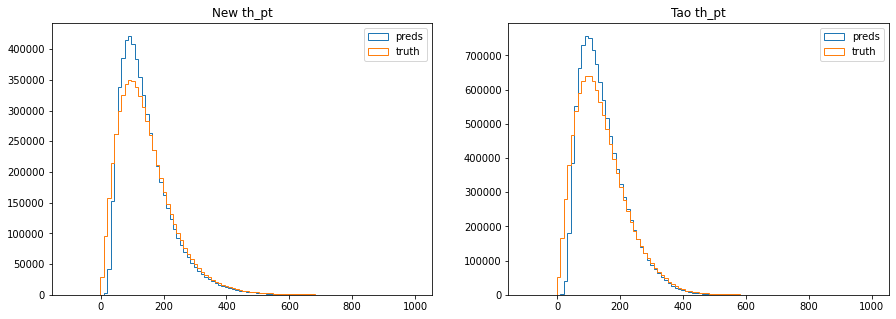

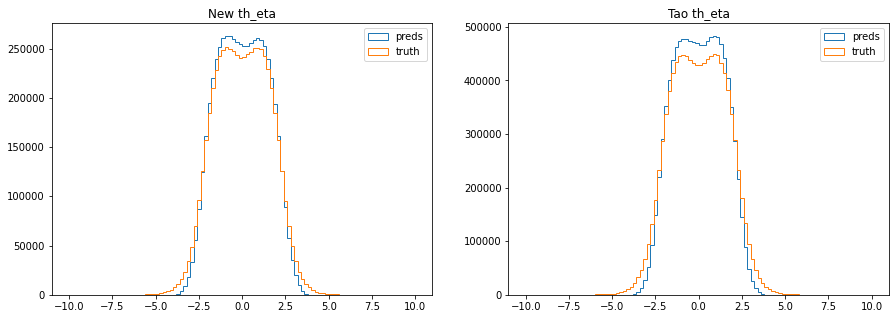

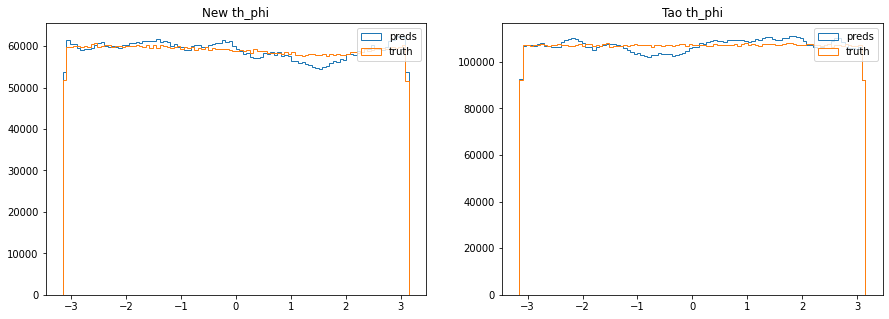

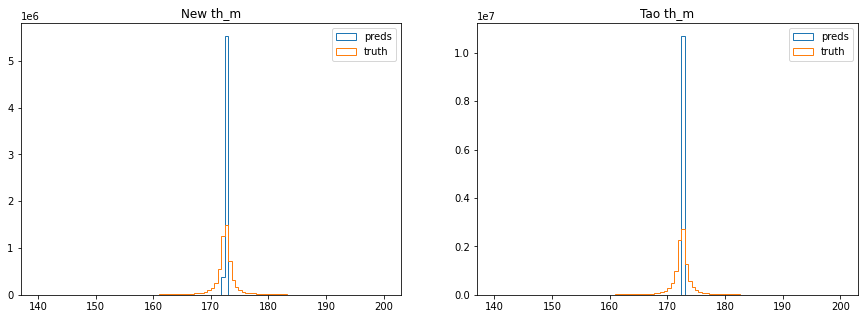

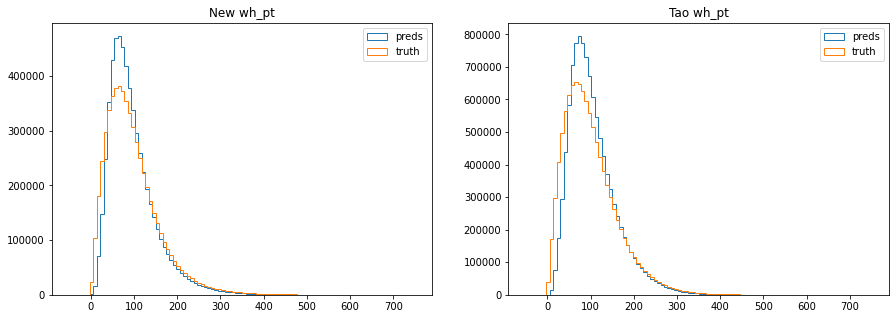

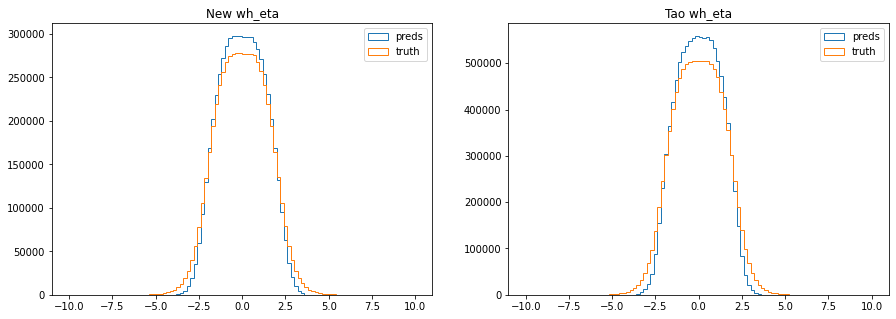

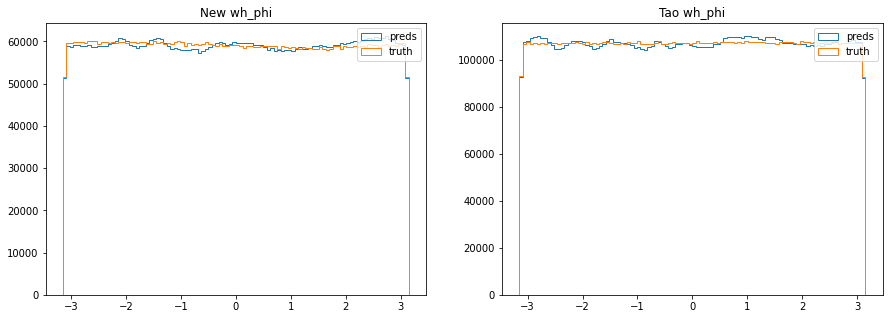

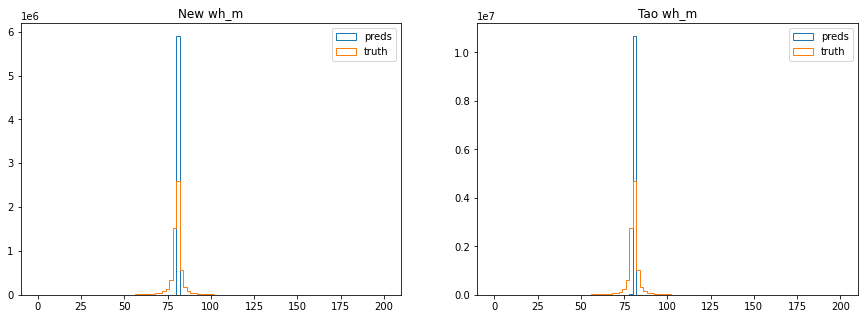

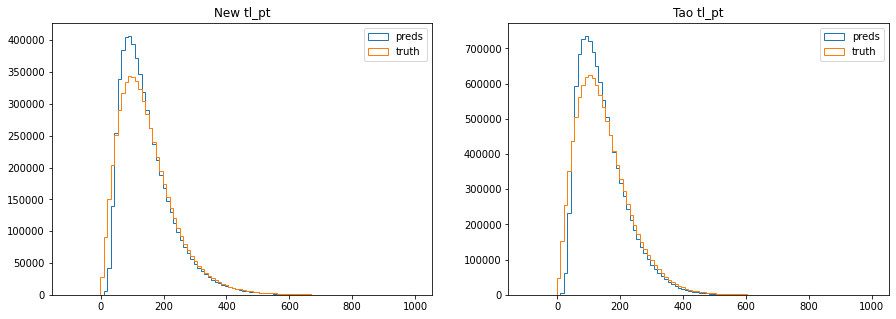

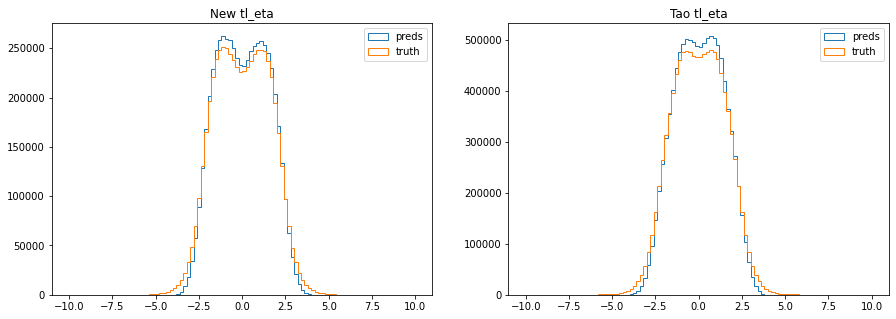

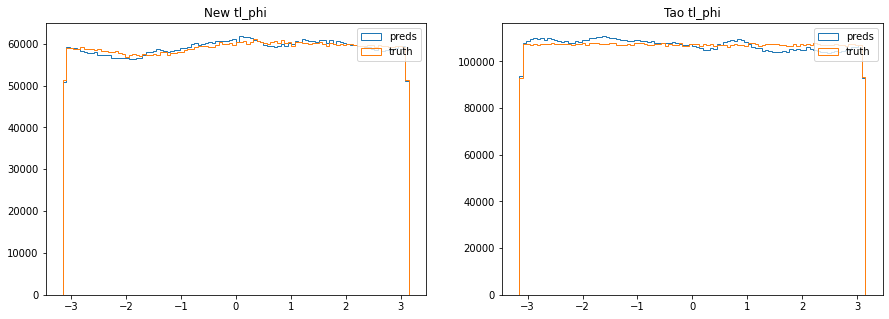

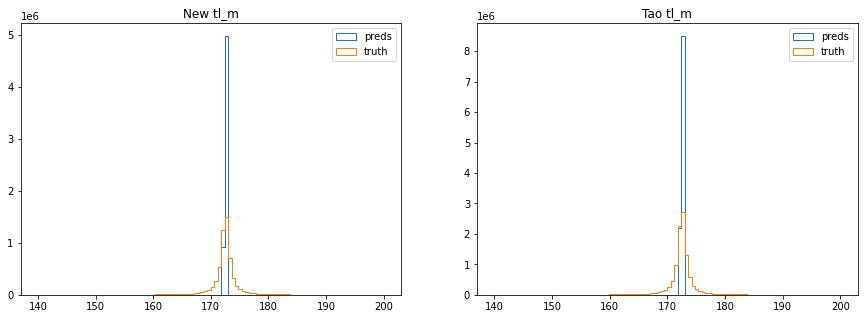

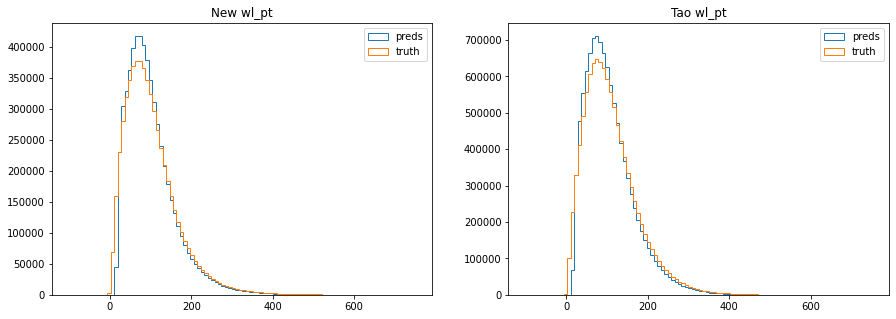

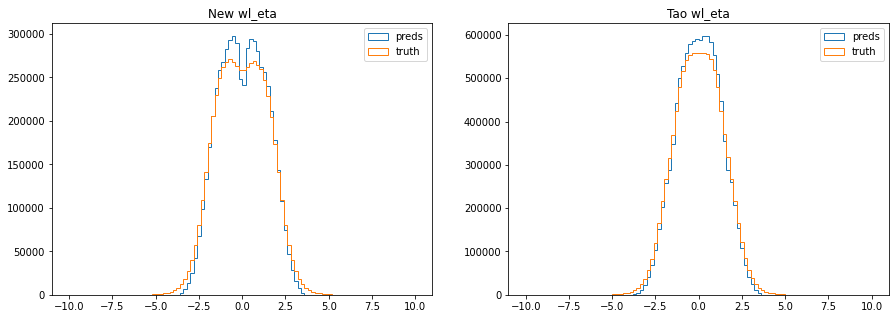

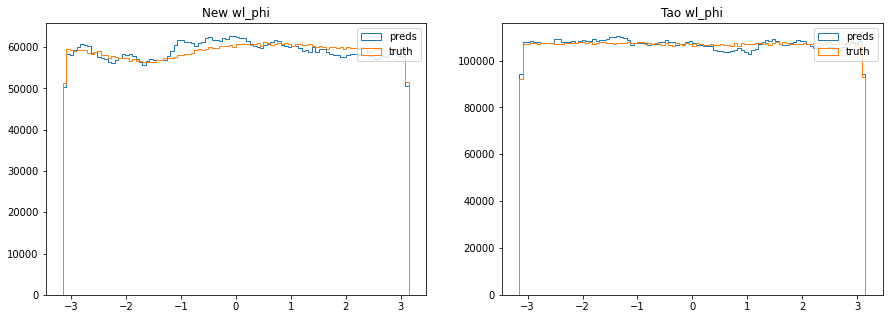

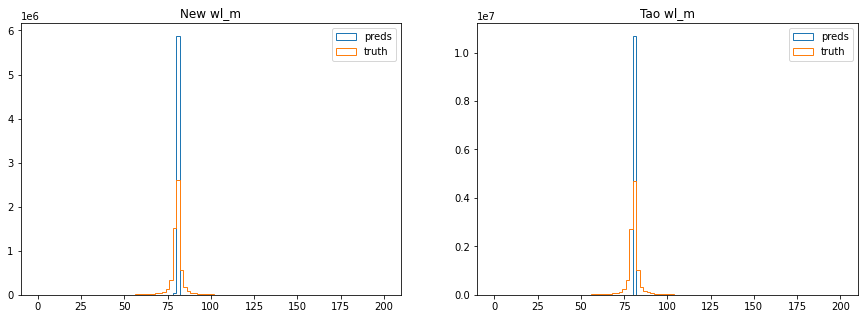

In [8]:
# Load the truth and predictions we just did
#focus = 'parton_e+mjets'
preds = np.load('/data/jchishol/Jenna_Data/preds_parton_'+focus+'.npy')
truth = np.load('/data/jchishol/Jenna_Data/true_parton_'+focus+'.npy')

# Load the truth and predictions from Tao's data (for comparison)
preds_tao = np.load('/data/jchishol/Tao_Data/preds_tao.npy')
truth_tao = np.load('/data/jchishol/Tao_Data/true_tao.npy')

# Need to set ranges to ensure everything is on the same scaling/bin sizes
ranges = {'th_pt': (-100,1000), 'th_eta':(-10,10),'th_phi':(-3.15,3.15), 'th_m': (140,200),'wh_pt': (-50,750), 'wh_eta':(-10,10),'wh_phi':(-3.15,3.15), 'wh_m': (0,200), 'tl_pt': (-100,1000), 'tl_eta':(-10,10),'tl_phi':(-3.15,3.15), 'tl_m': (140,200), 'wl_pt': (-100,750), 'wl_eta':(-10,10),'wl_phi':(-3.15,3.15), 'wl_m': (0,200)}


#Y_keys = ['th_pt', 'th_eta','th_phi','th_m', 'wh_pt', 'wh_eta', 'wh_phi', 'wh_m', 'tl_pt', 'tl_eta', 'tl_phi', 'tl_m', 'wl_pt', 'wl_eta', 'wl_phi', 'wl_m']
for i in range(len(truth.T)):
    
    # Create subplots
    fig, ax = plt.subplots(1,2, figsize = (15, 5))
    
    # Plot new data
    ax[0].set_title('New '+Y_keys[i])
    ax[0].hist(preds[:,i],bins=100,range=ranges[Y_keys[i]],histtype='step')
    ax[0].hist(truth[:,i],bins=100,range=ranges[Y_keys[i]],histtype='step')
    ax[0].legend(['preds','truth'])
        
    # Plot Tao's data
    ax[1].set_title('Tao '+Y_keys[i])
    ax[1].hist(preds_tao[:,i],bins=100,range=ranges[Y_keys[i]],histtype='step')
    ax[1].hist(truth_tao[:,i],bins=100,range=ranges[Y_keys[i]],histtype='step')
    ax[1].legend(['preds','truth'])

## Plot Inputs

/tmp/ipykernel_2906297/1434075834.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(var)


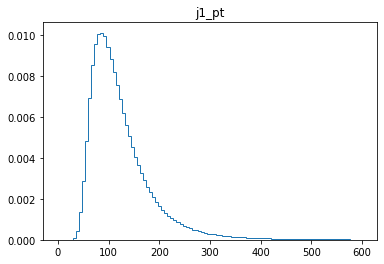

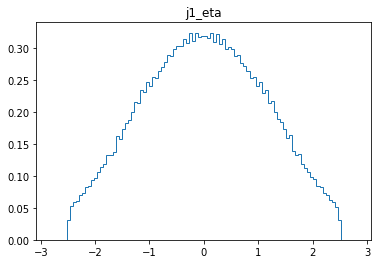

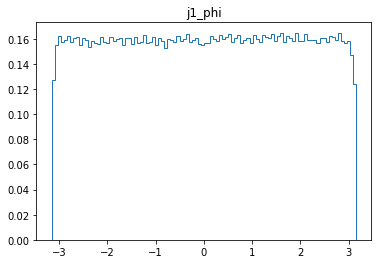

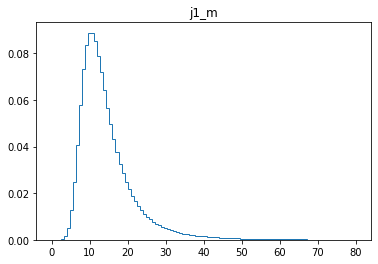

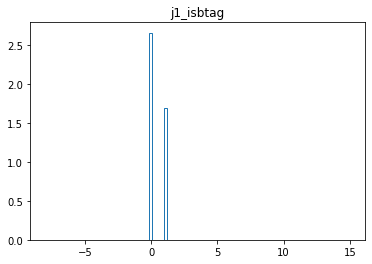

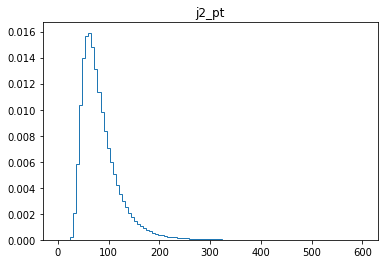

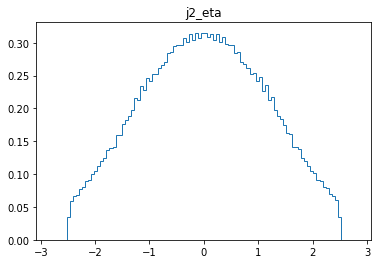

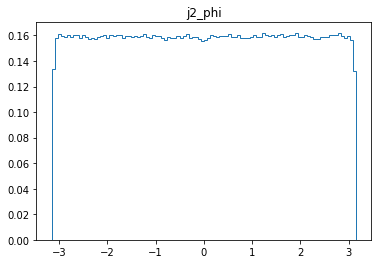

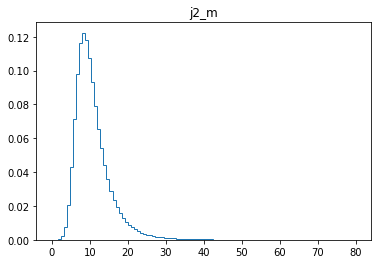

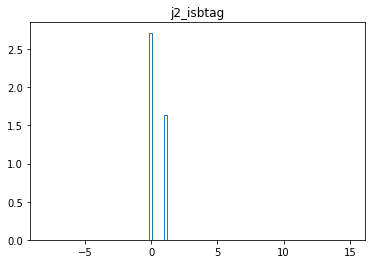

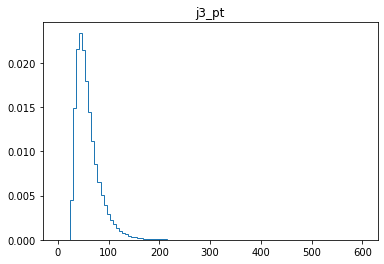

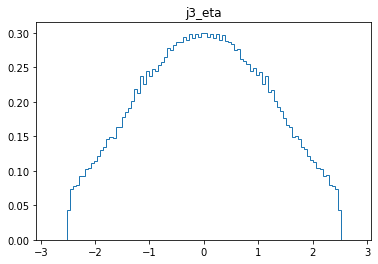

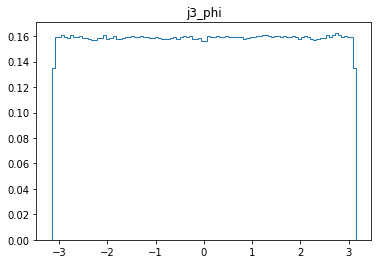

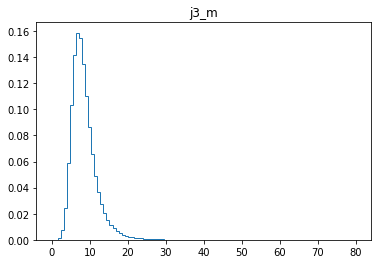

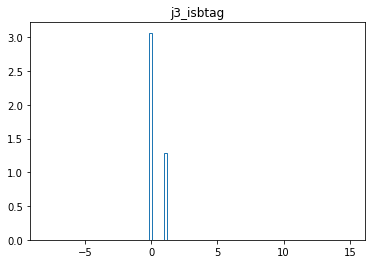

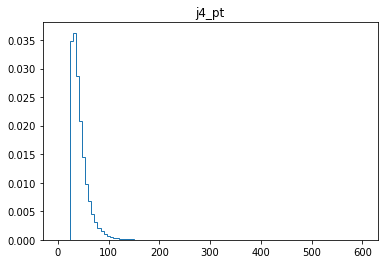

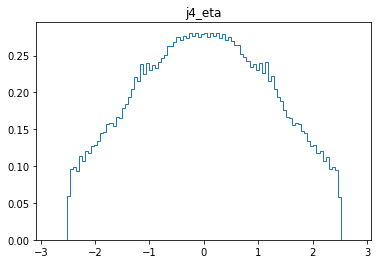

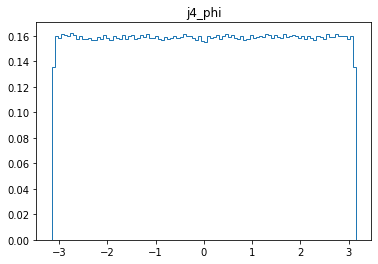

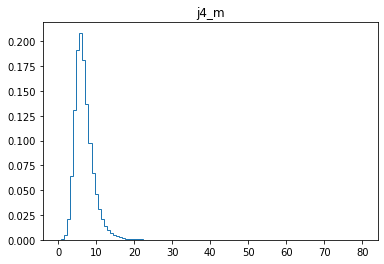

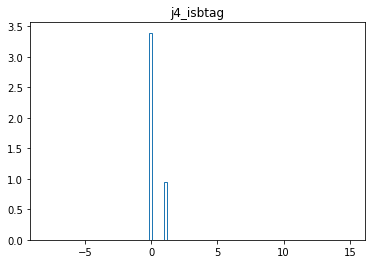

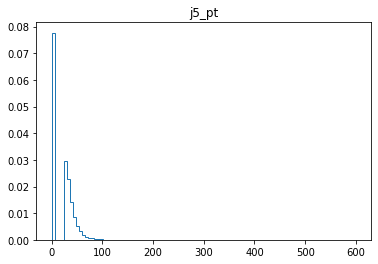

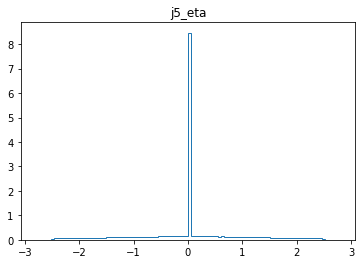

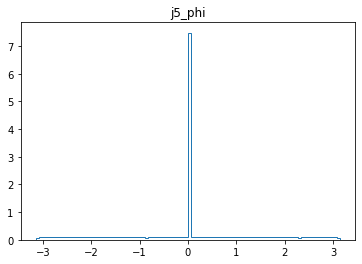

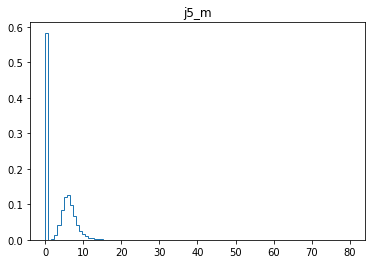

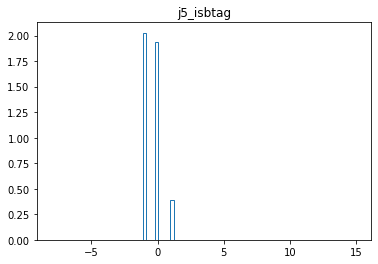

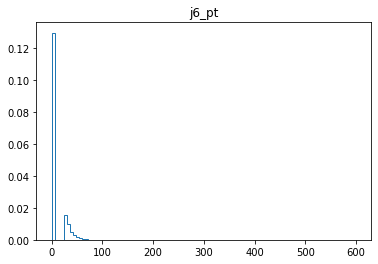

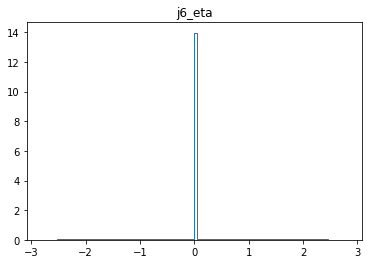

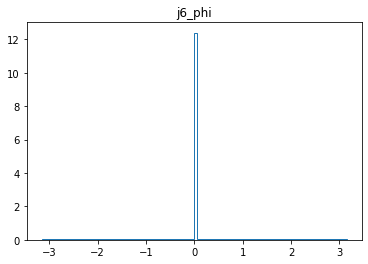

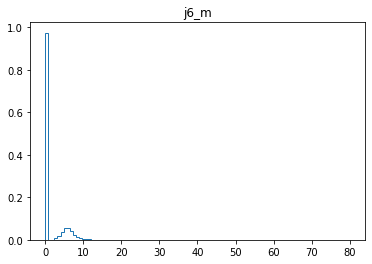

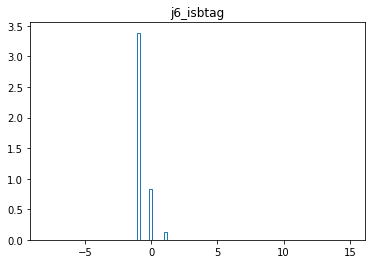

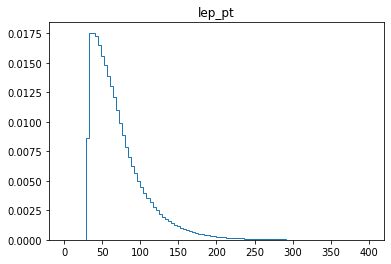

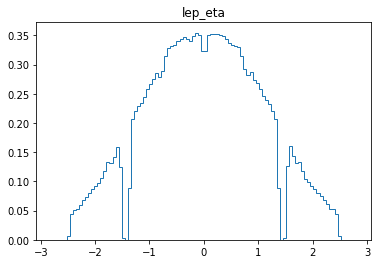

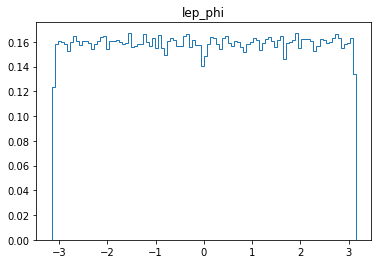

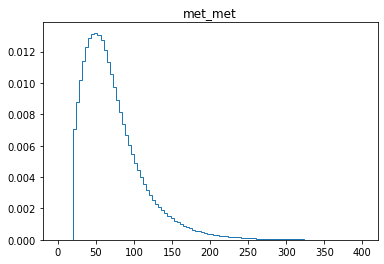

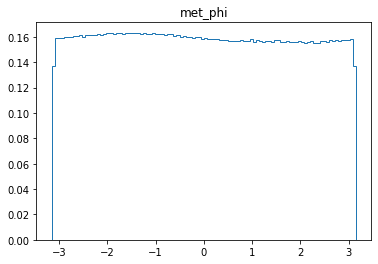

In [6]:
dataset_tao = h5py.File('/data/jchishol/Tao_Data/variables_tt_re_padded.h5','r')

ranges = {'j1_pt':(0,600),'j1_eta':(-2.8,2.8),'j1_phi':(-3.15,3.15),'j1_m':(0,80),'j1_isbtag':(-8,15),
         'j2_pt':(0,600),'j2_eta':(-2.8,2.8),'j2_phi':(-3.15,3.15),'j2_m':(0,80),'j2_isbtag':(-8,15),
         'j3_pt':(0,600),'j3_eta':(-2.8,2.8),'j3_phi':(-3.15,3.15),'j3_m':(0,80),'j3_isbtag':(-8,15),
         'j4_pt':(0,600),'j4_eta':(-2.8,2.8),'j4_phi':(-3.15,3.15),'j4_m':(0,80),'j4_isbtag':(-8,15),
         'j5_pt':(0,600),'j5_eta':(-2.8,2.8),'j5_phi':(-3.15,3.15),'j5_m':(0,80),'j5_isbtag':(-8,15),
         'j6_pt':(0,600),'j6_eta':(-2.8,2.8),'j6_phi':(-3.15,3.15),'j6_m':(0,80),'j6_isbtag':(-8,15),
         'lep_pt':(0,400), 'lep_eta':(-2.8,2.8),'lep_phi':(-3.15,3.15),'met_met':(0,400),'met_phi':(-3.15,3.15)}

for var in X_keys:
    plt.figure(var)
    plt.title(var)
    #plt.hist(np.array(dataset.get(var)),bins=100,density=True,histtype='step')
    plt.hist(np.array(dataset_tao.get(var)),bins=100,range=ranges[var],density=True,histtype='step')
    #plt.legend(['New','Tao'])

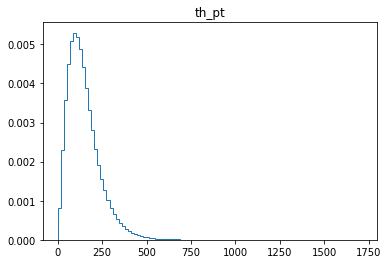

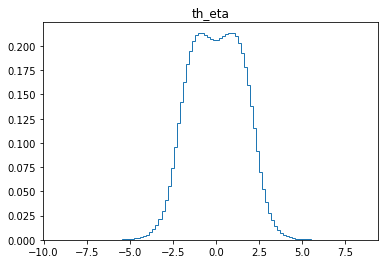

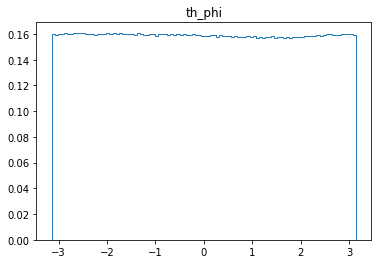

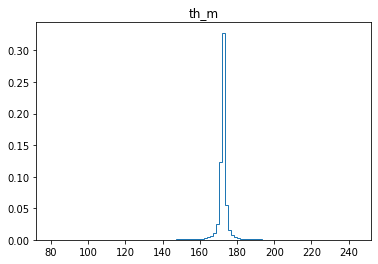

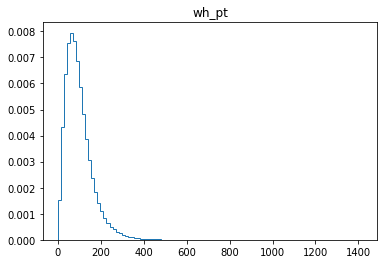

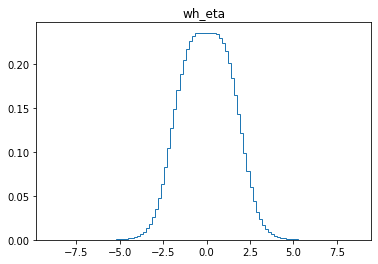

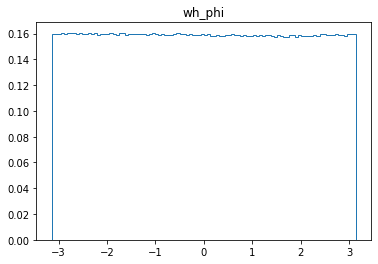

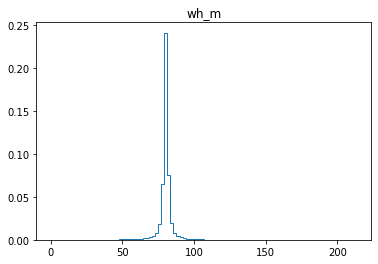

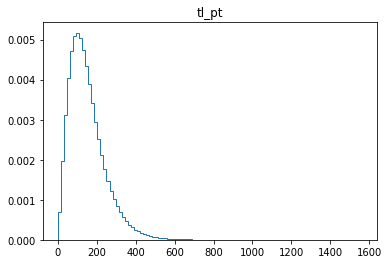

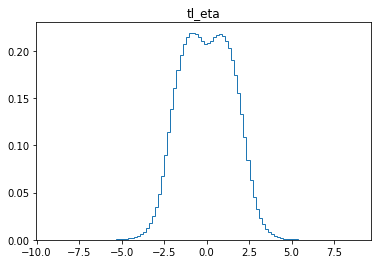

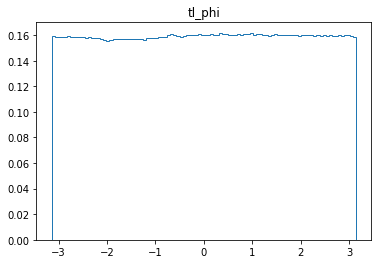

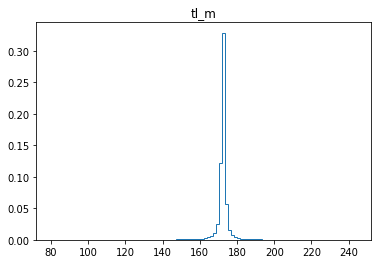

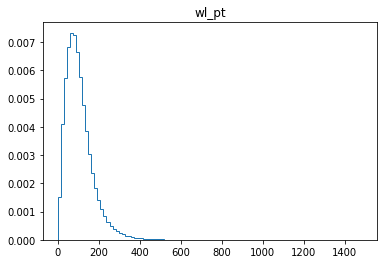

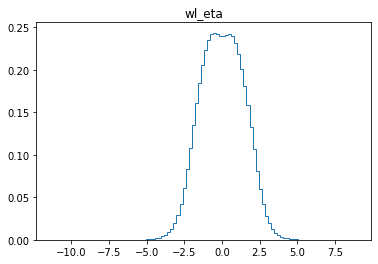

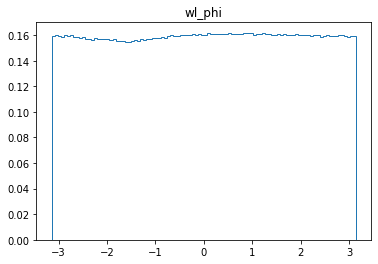

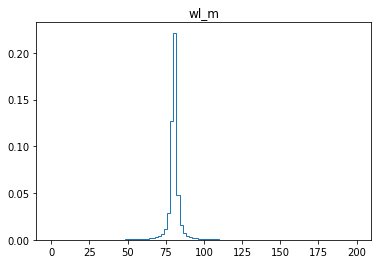

In [17]:
ranges = {'th_pt': (-100,1000), 'th_eta':(-10,10),'th_phi':(-3.15,3.15), 'th_m': (140,200),'wh_pt': (-50,750), 'wh_eta':(-10,10),'wh_phi':(-3.15,3.15), 'wh_m': (0,200), 'tl_pt': (-100,1000), 'tl_eta':(-10,10),'tl_phi':(-3.15,3.15), 'tl_m': (140,200), 'wl_pt': (-100,750), 'wl_eta':(-10,10),'wl_phi':(-3.15,3.15), 'wl_m': (0,200)}

for var in Y_keys:
    plt.figure(var)
    plt.title(var)
    plt.hist(np.array(dataset.get(var)),bins=100,density=True,histtype='step')
    #plt.hist(np.array(dataset_tao.get(var)),bins=100,range=ranges[var],density=True,histtype='step') 
    #plt.legend(['New','Tao'])

## Plot Scaled Inputs

<ipython-input-12-528efb09ba0f>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(X_names[i])


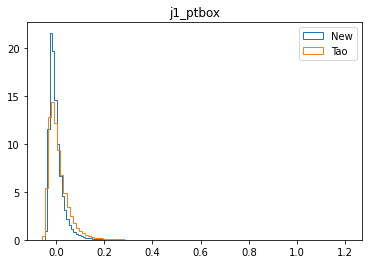

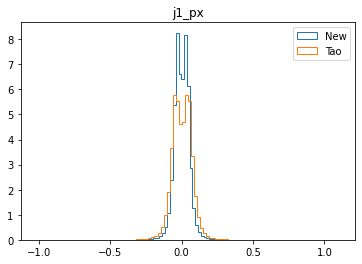

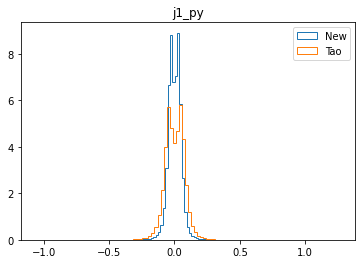

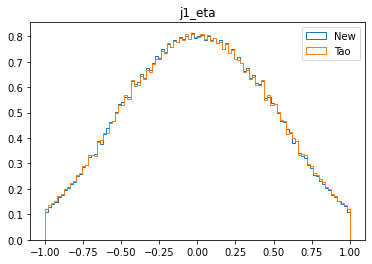

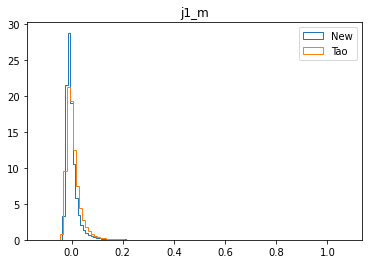

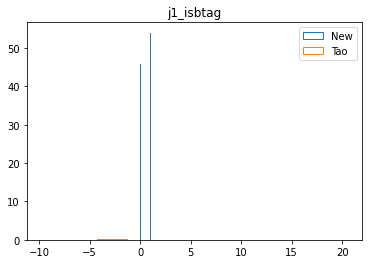

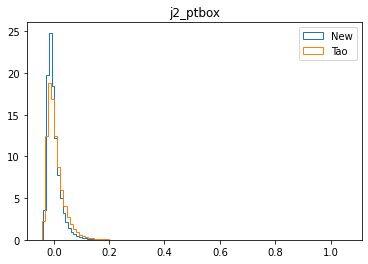

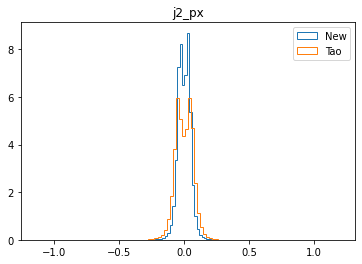

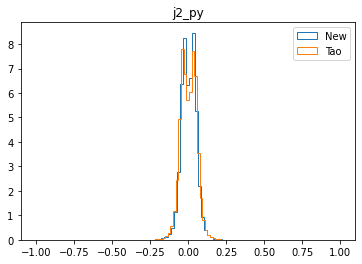

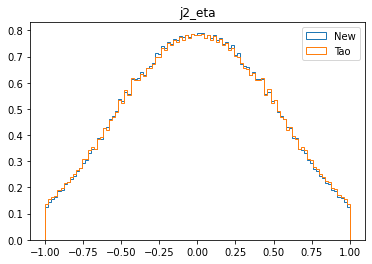

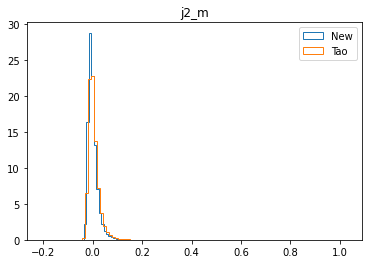

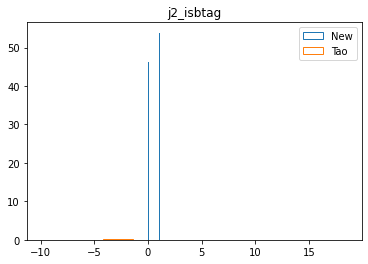

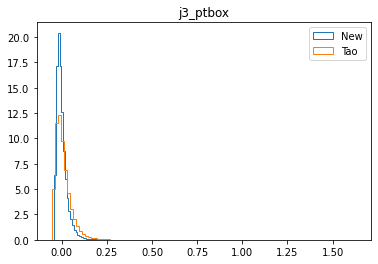

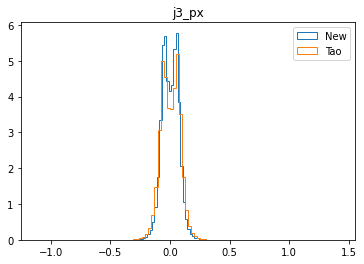

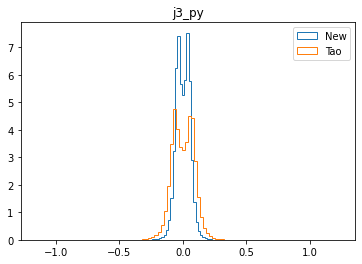

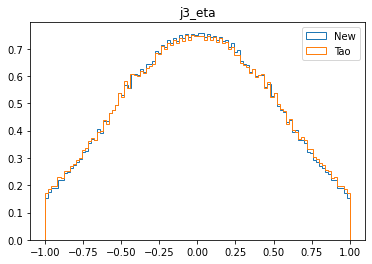

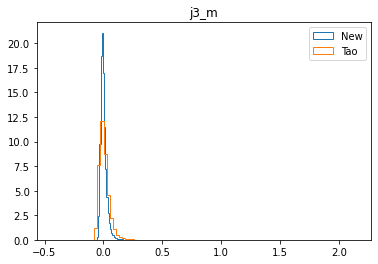

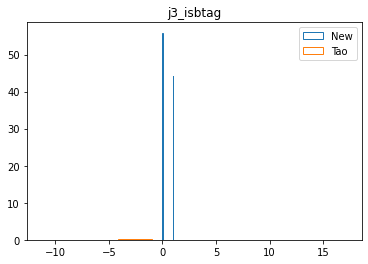

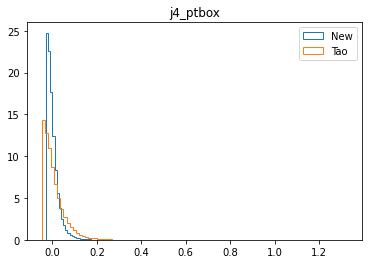

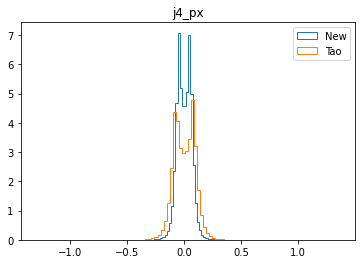

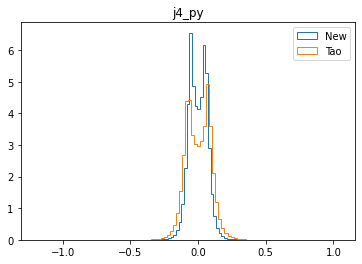

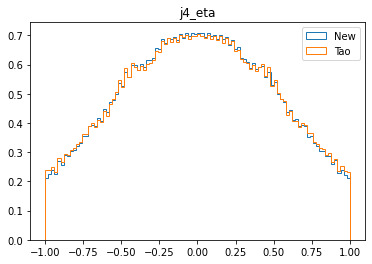

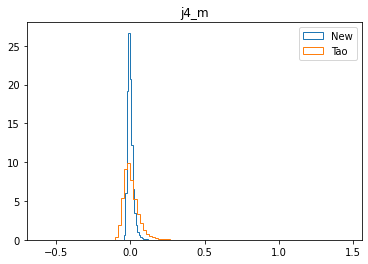

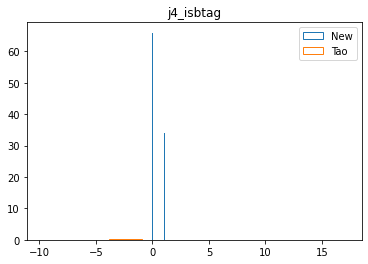

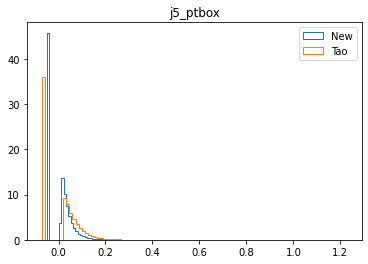

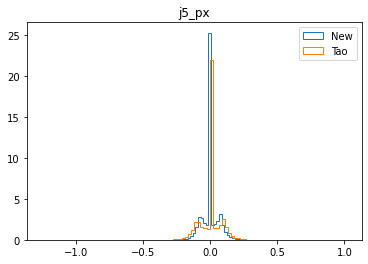

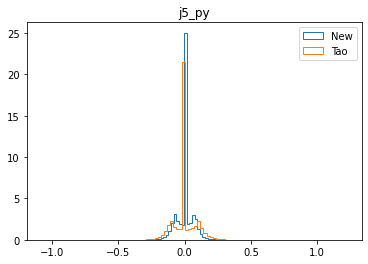

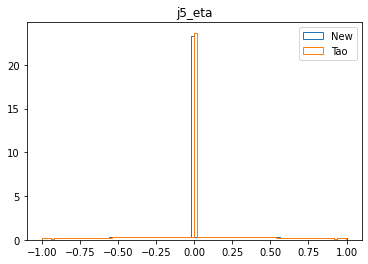

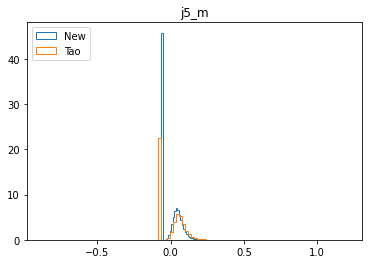

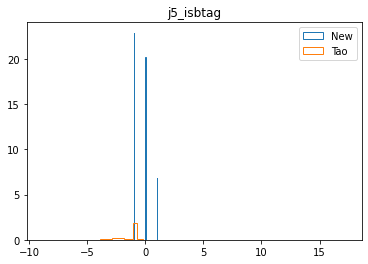

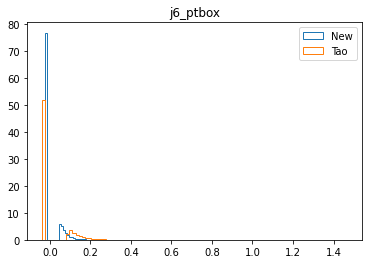

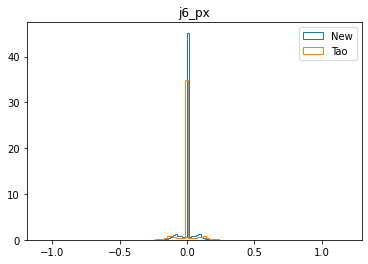

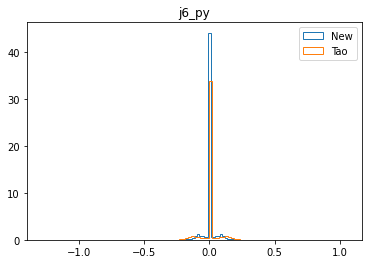

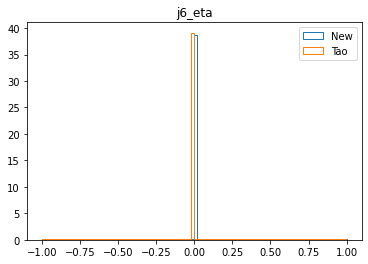

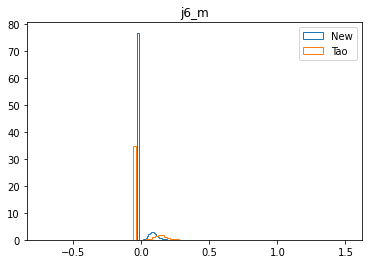

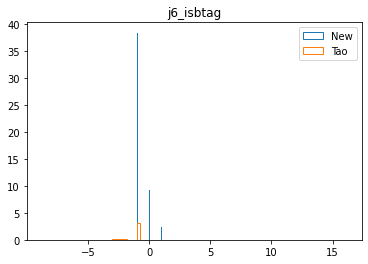

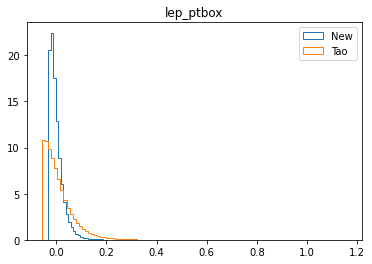

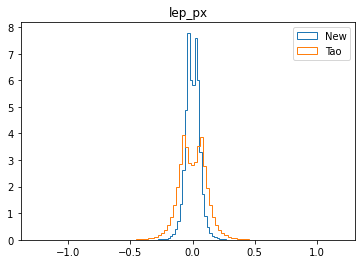

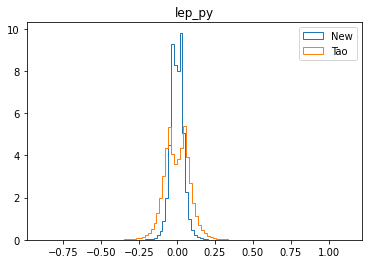

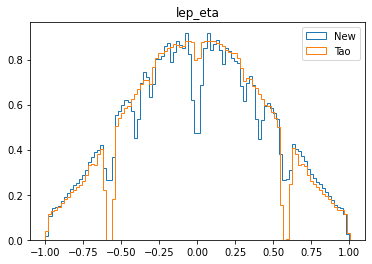

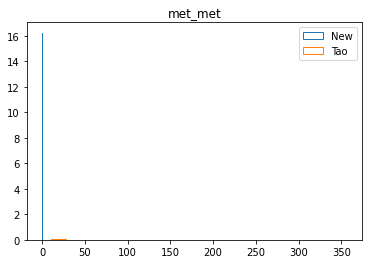

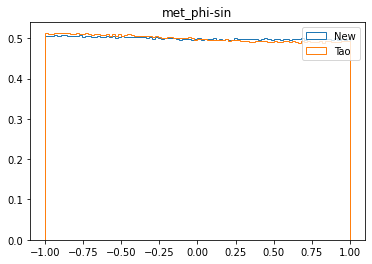

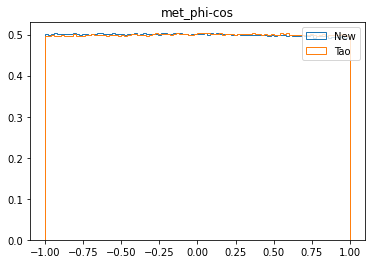

In [12]:
X_Tao = np.load('/data/jchishol/Tao_Data/X_scaled_Tao.npy')
Y_Tao = np.load('/data/jchishol/Tao_Data/Y_scaled_Tao.npy')

for i in range(len(X_total[0])):
    plt.figure(X_names[i])
    plt.title(X_names[i])
    plt.hist(X_total[:,i],bins=100,density=True,histtype='step')
    plt.hist(X_Tao[:,i],bins=100,density=True,histtype='step')
    plt.legend(['New','Tao'])  

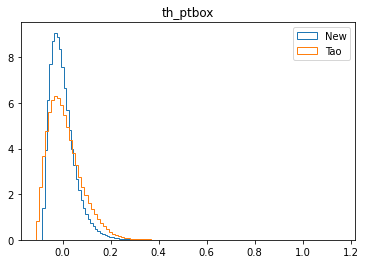

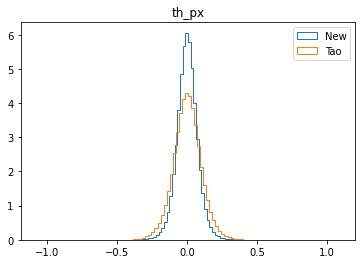

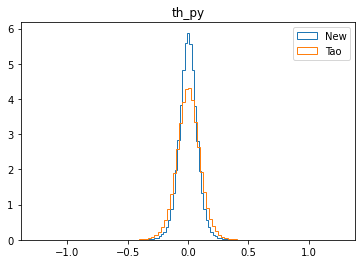

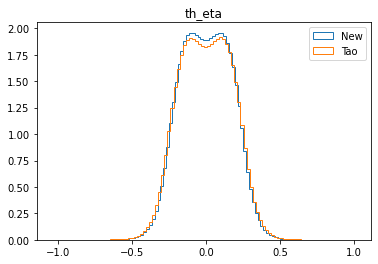

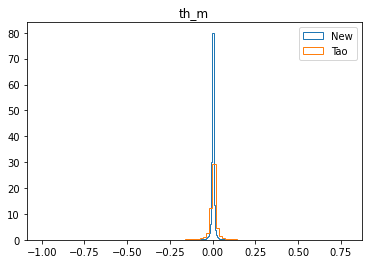

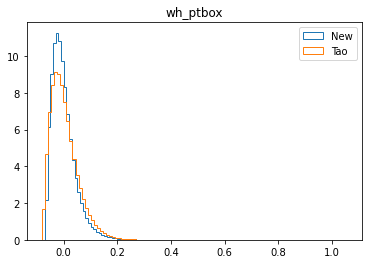

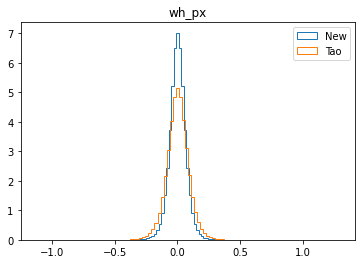

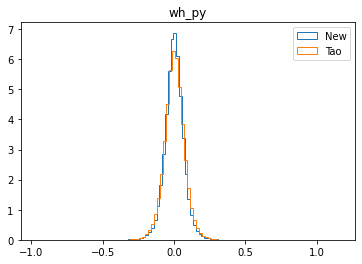

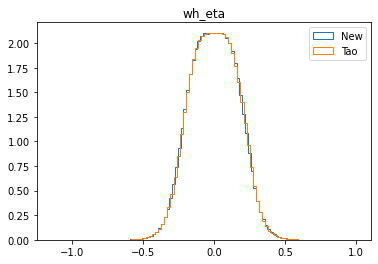

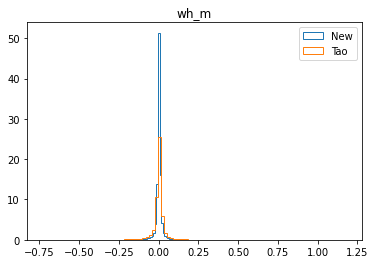

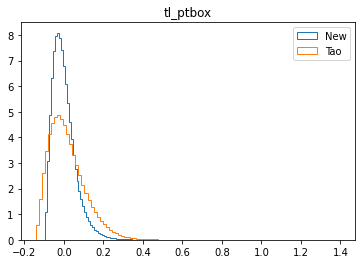

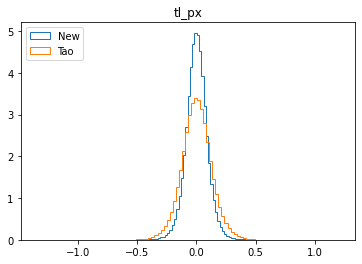

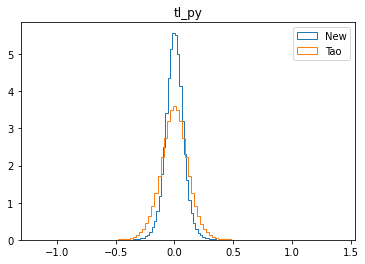

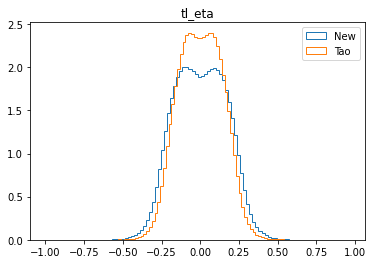

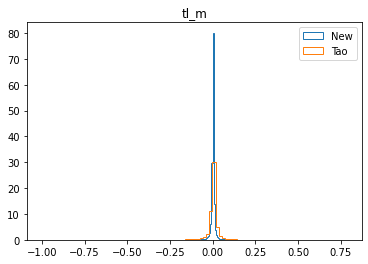

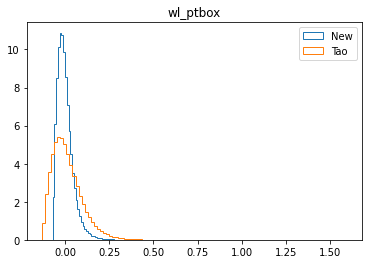

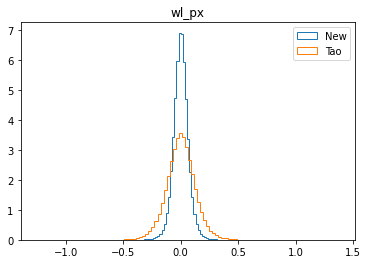

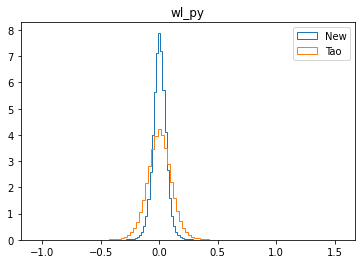

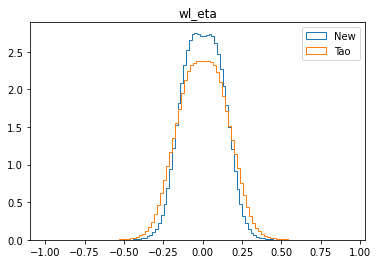

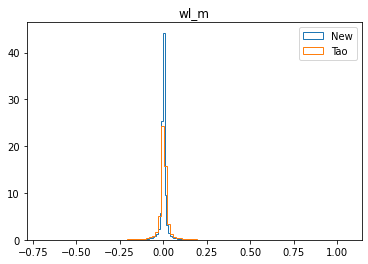

In [13]:
for i in range(len(Y_total[0])):
    plt.figure(Y_names[i])
    plt.title(Y_names[i])
    plt.hist(Y_total[:,i],bins=100,density=True,histtype='step')
    plt.hist(Y_Tao[:,i],bins=100,density=True,histtype='step')
    plt.legend(['New','Tao'])

In [14]:
print('X: ')
for i in range(len(X_total[0])):
    print('Tao scaled max: %f      New scaled max %f' % (max(abs(X_Tao[:,i])),max(abs(X_total[:,i]))))

X: 
Tao scaled max: 1.205671      New scaled max 0.941811
Tao scaled max: 1.110158      New scaled max 1.000111
Tao scaled max: 1.267837      New scaled max 1.000085
Tao scaled max: 1.000000      New scaled max 1.000314
Tao scaled max: 1.074749      New scaled max 0.955731
Tao scaled max: 20.414389      New scaled max 1.000000
Tao scaled max: 1.057912      New scaled max 0.947634
Tao scaled max: 1.199804      New scaled max 1.000049
Tao scaled max: 1.004649      New scaled max 1.000047
Tao scaled max: 0.999999      New scaled max 1.000169
Tao scaled max: 1.026539      New scaled max 0.954583
Tao scaled max: 18.507067      New scaled max 1.000000
Tao scaled max: 1.630924      New scaled max 0.932372
Tao scaled max: 1.426951      New scaled max 0.999898
Tao scaled max: 1.236731      New scaled max 1.000082
Tao scaled max: 1.000001      New scaled max 1.000439
Tao scaled max: 2.144947      New scaled max 0.936757
Tao scaled max: 17.166092      New scaled max 1.000000
Tao scaled max: 1.323

In [15]:
print('Y: ')
for i in range(len(Y_total[0])):
    print('Tao scaled max: %f      New scaled max %f' % (max(abs(Y_Tao[:,i])),max(abs(Y_total[:,i]))))

Y: 
Tao scaled max: 1.156182      New scaled max 0.914550
Tao scaled max: 1.094679      New scaled max 1.000172
Tao scaled max: 1.258186      New scaled max 1.000418
Tao scaled max: 1.039153      New scaled max 0.999992
Tao scaled max: 0.997931      New scaled max 0.376302
Tao scaled max: 1.054511      New scaled max 0.930798
Tao scaled max: 1.296641      New scaled max 1.000111
Tao scaled max: 1.165219      New scaled max 1.000254
Tao scaled max: 1.139509      New scaled max 1.000000
Tao scaled max: 1.181522      New scaled max 0.623673
Tao scaled max: 1.399035      New scaled max 0.903988
Tao scaled max: 1.352365      New scaled max 0.999739
Tao scaled max: 1.409961      New scaled max 0.999458
Tao scaled max: 0.945096      New scaled max 0.999490
Tao scaled max: 0.999682      New scaled max 0.376452
Tao scaled max: 1.591648      New scaled max 0.929761
Tao scaled max: 1.386659      New scaled max 0.999772
Tao scaled max: 1.546583      New scaled max 0.999507
Tao scaled max: 0.948669